# ECE 417  MP5: Face Detection using Faster RCNN

This MP is an implementation of the <a href="http://papers.nips.cc/paper/5638-faster-r-cnn-towards-real-time-object-detection-with-region-proposal-networks.pdf">Faster RCNN</a> object detector, to perform <a href="https://ieeexplore.ieee.org/abstract/document/7961803?casa_token=Iq_WWzkvf9UAAAAA:ObgVQqkbTdwZ5KEPLAUK6uABkfEMT0F7TUm_Y0mNOr5uEbFGY3cVN0mo8JQHqboUNsZtCEoa">face detection</a> using a small dataset extracted from the very large <a href="http://shuoyang1213.me/WIDERFACE/">WIDER FACE</a> dataset.

In [4]:
import numpy  as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.figure
import importlib, os, sys, h5py
import submitted

## 0. Browsing the Data

First, we'll create a function that plots face rectangles on top  of the image.  Then we'll use it to look at some of the data.

In [7]:
def show_image_with_rectangles(image,rects):
    fig=plt.figure(figsize=(7,7))
    plt.imshow(image)
    for rect in rects:
        x = rect[0]+np.array([-rect[2]/2,rect[2]/2])
        y = rect[1]+np.array([-rect[3]/2,rect[3]/2])
        plt.plot(x,y[0]*np.ones(2),'c-',linewidth=3)
        plt.plot(x,y[1]*np.ones(2),'c-',linewidth=3)
        plt.plot(x[0]*np.ones(2),y,'c-',linewidth=3)
        plt.plot(x[1]*np.ones(2),y,'c-',linewidth=3)

The dataset is provided to you as a set of 50 images, with their extracted features, and their labels.  

These things are available so that you can look at the data.  They are not actually  going to be used by the neural net:
* `images` ($N_{toks}$,224,224,3) contains $N_{toks}=50$ RGB images, each of which is $224\times 224$ pixels
* `rects` ($N_{toks}$,10,10) contains up to 10 original WIDER-dataset rectangles for each image.

These are the  things the neural net will actually use.  They have been computed for you from the data above:
* `features` ($N_{toks}$,$N_1$,$N_2$,$N_C$) contains a $N_1\times N_2\times N_C$ feature tensor for each image.  This feature tensor was computed by a CNN, from the data in `images`, with 4 stages of max-pooling, and with $N_C=512$ output channels  per pixel.  That would result in a $14\times 14\times N_C$ tensor, but in order to reduce the amount of computation for this MP, we have retained only the $N_1=8$ rows and $N_2=8$ columns nearest the center of the image.
* `targets` $(N_{toks},N_1,N_2,N_A,N_Y)$ provides the regression and classification neural net targets (total dimension: $N_Y=5$) for each of $N_A=9$ anchor rectangles centered at  each of the $N_1\times  N_2$ max-pooled pixel locations.  These are computed from the `rects`.


In [13]:
#import submitted
#importlib.reload(submitted)
#dataset = submitted.Dataset('data')
#datum=dataset[0]
#for k in datum.keys():
#    print('Object %s has shape %s'%(k,datum[k].shape))
with h5py.File('data.hdf5','r') as f:
    features = f['features'][:]
    rects = f['rects'][:]
    targets = f['targets'][:]
    anchors = f['anchors'][:]
with h5py.File('images.hdf5','r') as f:
    images = f['images'][:]
print('The input to the neural net are the features, whose shape is',features.shape)
print('The neural net target output is target, whose shape is',targets.shape)
print('The images are available if we want to look at them, their shape is ',images.shape)
print('The original WIDER rectangle definitions, too.  Their shape is',rects.shape)

The input to the neural net are the features, whose shape is (50, 8, 8, 512)
The neural net target output is target, whose shape is (50, 8, 8, 9, 5)
The images are available if we want to look at them, their shape is  (50, 224, 224, 3)
The original WIDER rectangle definitions, too.  Their shape is (50, 10, 10)


The two layers of the Faster RCNN are 

1. A $3\times 3$ convolutional layer, with $N_C=512$ input channels, thus

$$\xi^{(1)}[n_1,n_2,d] = \sum_{c=0}^{N_C-1}\sum_{m_1=-1}^{1}\sum_{m_2=-1}^{1}w^{(1)}[m_1,m_2,c,d]x[n_1-m_1,n_2-m_2,c]$$
$$h[n_1,n_2,d]=\mbox{ReLU}\left(\xi^{(1)}[n_1,n_2,d]\right),$$
and `W1.shape` is $(M_1,M_2,N_C,C_D)=(3,3,512,128)$.

2. A $1\times 1$ convolution, with $N_D=128$ input channels, and $N_A\times N_Y$ outputs.  The $N_A\times N_Y$ outputs match the last two dimensions of the `target` array: they correspond to $N_A$ anchor rectangles ($a$) per position, with $N_Y$ outputs per anchor rectangle, thus:

$$\xi^{(2)}[n_1,n_2,a,k]=\sum_d w^{(2)}[0,0,d,a,k]h[n_1,n_2,d]$$

and `W2.shape` is $(1,1,N_D,N_A,N_Y)=(1,1,128,9,5)$.  Notice that this layer is described as a "$1\times 1$ convolution," and you could implement it that way, where the tensor $h[:,:,:]$ is convolving by the filter $w^{(2)}[:,:,:,:,k]$.  Alternatively, you could just implement it as a matrix multiplication, where each vector $h[n_1,n_2,:]$ is multiplied by the matrix $w^{(2)}[0,0,:,:,k]$.  Either implementation should work (the ECE 417 staff have tried both).

The W1 and W2 tensors have been initialized to some small random values in the file `weights_initial.hdf5`:

In [14]:
with h5py.File('weights_initial.hdf5','r') as f:
    W1=f['W1'][:]
    W2=f['W2'][:]
print('W1 has shape',W1.shape)
print('W2 has shape',W2.shape)

W1 has shape (3, 3, 512, 128)
W2 has shape (1, 1, 128, 9, 5)


Neural network weights are never initialized to be all zeros, because if all of the columns in W1 are the same to begin with, then they will also have the same gradients.  If they have the same gradient, then they remain the same after training, and so we wind up with a W1 matrix that has the same elements in every row -- a result that's guaranteed to have suboptimal performance.  Instead, neural network weights are initialized to some small random values.

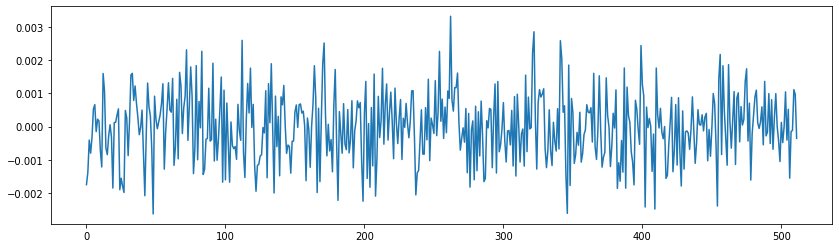

In [15]:
fig = plt.figure(figsize=(14,4))
plt.plot(np.arange(512),W1[0,0,:,0])

Next, let's plot an image, and overlay its reference rectangles on top:

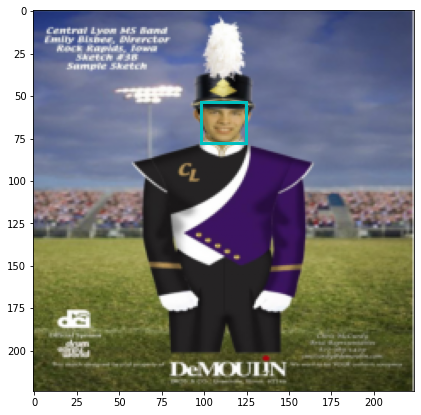

In [16]:
show_image_with_rectangles(images[0,:,:,:]/255,rects[0,:,:])

The `anchors`  are the set of anchor rectangles.  They are the same for every image.  There are $N_A=9$ anchor rectangles,  for each of $N_1\times N_2$ pixel locations.  Each rectangle has 4 numbers: x, y, width, and height.
Thus, `anchors` is an array of size $(N_1,N_2,N_A,4)$.

In [17]:
with h5py.File('data.hdf5','r') as f:
    anchors = f['anchors'][:]
print(anchors.shape)

(8, 8, 9, 4)


There are  $N_A$ anchors associated with each of $N_1\times N_2$ positions.  The smallest anchor associated with each position is the $0^{\textrm{th}}$ rectangle; let's plot that one first, for all $N_1\times N_2$ positions.

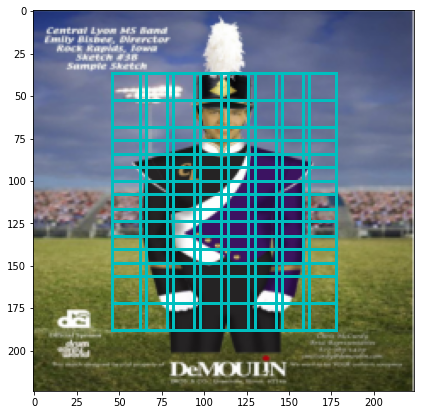

In [18]:
show_image_with_rectangles(images[0,:,:,:],anchors[:,:,0,:].reshape((8*8,4)))

The 9 anchors  associated with any given position are 9 different rectangles with 3 different sizes (small, medium, large) $\times$ 3 different aspect ratios (horizontal, square, vertical).  Let's plot all 9 of them, for the position in the middle of the image.

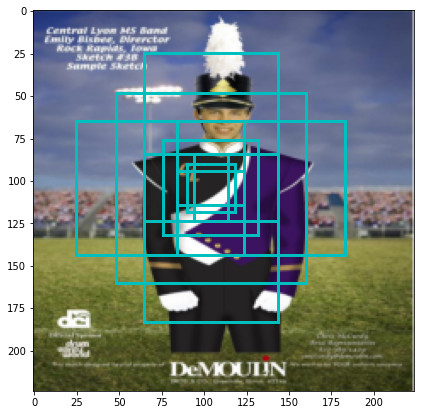

In [19]:
show_image_with_rectangles(images[0,:,:,:],anchors[3,3,:,:])

Finally: the classification targets and regression targets are encoded into the array called `targets`.  Specifically, the binary classification target for the $a^{\textrm{th}}$ anchor at the $(x,y)^{\textrm{th}}$ position in the $i^{\textrm{th}}$ image is encoded as targets[i,x,y,a,4], and if the classification target is 1, then the regression target is encoded as targets[i,a,x,y,0:4].  

The way in which they're coded is given in the paper https://proceedings.neurips.cc/paper/2015/file/14bfa6bb14875e45bba028a21ed38046-Paper.pdf, and also in the function `submitted.regression_rects`, which is provided to you as a utility function.  The following  code inverts that encoding, to get the original rectangles back again as [x,y,w,h] vectors.

Notice the min(np.log(2),regression_target) here.  That keeps the computed rectangle from ever being more than twice as large as the anchor rectangle.  I recommend that you use such a limit in your code, because sometimes the neural net outputs get very large.

In [20]:
def target2rect(regression_target, anchor):
    rect = np.zeros(4)
    rect[0] = regression_target[0]*anchor[2]+anchor[0]
    rect[1] = regression_target[1]*anchor[3]+anchor[1]
    rect[2] = np.exp(min(np.log(2),regression_target[2]))*anchor[2]
    rect[3] = np.exp(min(np.log(2),regression_target[3]))*anchor[3]
    return(rect)

The Faster-RCNN coding scheme creates a target whenever a reference rectangle and an anchor rectangle have an IoU (intersection-over-union) greater than 0.7.  For that reason, there are a lot more target rectangles than there were reference rectangles.  When we decode them using `target2rect`, though, it turns out that they are multiple copies of the same rectangle:

In [21]:
target_rects = []
for n1 in range(8): # 8 positions in N1
    for n2 in range(8): # 8 positions in N2
        for a  in range(9): # 9 anchors per position
            if targets[0,n1,n2,a,4]==1:
                rect = target2rect(targets[0,n1,n2,a,0:4],anchors[n1,n2,a,:])
                target_rects.append(rect)
                print('x=%d, y=%d, a=%d, target (%2.2f,%2.2f,%2.2f,%2.2f)'%(n1,n2,a,*targets[0,n1,n2,a,0:4]),
                        'becomes rect (%2.2f,%2.2f,%2.2f,%2.2f)'%(rect[0],rect[1],rect[2],rect[3]))
print('There are %d target rectangles for this image'%(len(target_rects)))

x=0, y=4, a=0, target (2.81,-1.38,0.30,-0.50) becomes rect (111.56,65.42,26.69,24.10)
x=0, y=4, a=1, target (1.98,-1.95,-0.05,-0.15) becomes rect (111.56,65.42,26.69,24.10)
x=0, y=5, a=1, target (1.98,-2.52,-0.05,-0.15) becomes rect (111.56,65.42,26.69,24.10)
x=0, y=5, a=2, target (1.40,-3.56,-0.39,0.20) becomes rect (111.56,65.42,26.69,24.10)
x=0, y=6, a=2, target (1.40,-4.37,-0.39,0.20) becomes rect (111.56,65.42,26.69,24.10)
x=0, y=7, a=2, target (1.40,-5.18,-0.39,0.20) becomes rect (111.56,65.42,26.69,24.10)
x=1, y=4, a=0, target (2.00,-1.38,0.30,-0.50) becomes rect (111.56,65.42,26.69,24.10)
x=1, y=5, a=0, target (2.00,-1.78,0.30,-0.50) becomes rect (111.56,65.42,26.69,24.10)
x=1, y=6, a=0, target (2.00,-2.19,0.30,-0.50) becomes rect (111.56,65.42,26.69,24.10)
x=1, y=6, a=1, target (1.41,-3.09,-0.05,-0.15) becomes rect (111.56,65.42,26.69,24.10)
x=1, y=7, a=1, target (1.41,-3.66,-0.05,-0.15) becomes rect (111.56,65.42,26.69,24.10)
x=6, y=5, a=0, target (-2.04,-1.78,0.30,-0.50) bec

If we plot the target rectangles, though, we should see that the number of __distinct__ target rectangles is just the same as the number of reference rectangles.  All of the extra targets are just duplicates of the same original references:

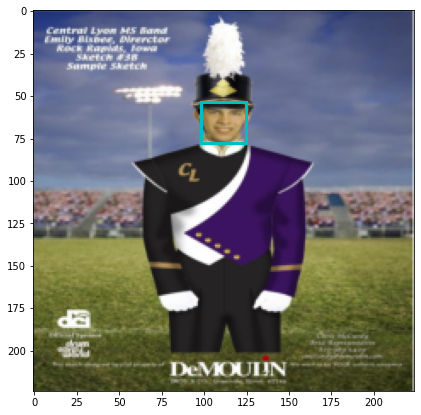

In [22]:
show_image_with_rectangles(images[0,:,:,:],target_rects)

Now that we've seen all of those things for one of the data, go up to the top of this section and choose image \#1, or \#2, or \#49  (any number less than 50), in order to look at a different image.

## 1. Provided Utility Functions: conv2, conv_layer, and sigmoid

In an attempt to make your  life a little easier, you are provided with a some utility functions.  

The first one, `conv2`, just performs a 2d convolution.  It is unusual in just one  respect: if its inputs have the sizes (N1,N2) and (M1,M2), its  output always has the size (N1-M1+1+2$\times$padding,N2-M2+1+2$\times$padding).  This is the same as zero-padding `H` by `padding` rows and columns prior to convolution, and then convolving using 'valid' mode.  

Let's test it by convolving a zero-padded square and an unpadded square; the output should be a square pyramid.

In [23]:
importlib.reload(submitted)
help(submitted.conv2)

Help on function conv2 in module submitted:

conv2(H, W, padding)
    Compute a 2D convolution.  Compute only the valid outputs, after padding H with 
    specified number of rows and columns before and after.
    
    Input:
      H (N1,N2) - input image
      W (M1,M2) - impulse response, indexed from -M1//2 <= 
      padding (scalar) - number of rows and columns of zeros to pad before and after H
    
    Output:
      Xi  (N1-M1+1+2*padding,N2-M2+1+2*padding) - output image
         The output image is computed using the equivalent of 'valid' mode,
         after padding H  with "padding" rows and columns of zeros before and after the image.
    
    Xi[n1,n2] = sum_m1 sum_m2 W[m1,m2] * H[n1-m1,n2-m2]



Text(0.5, 1.0, 'pyramid')

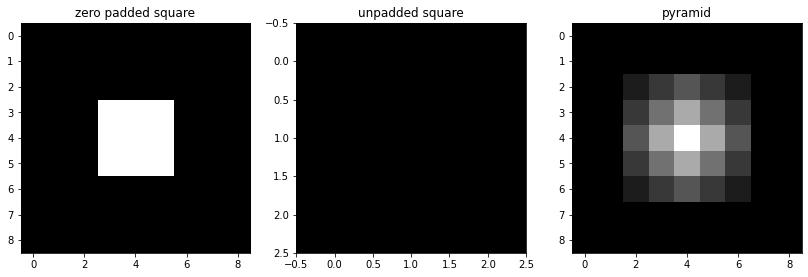

In [24]:
importlib.reload(submitted)
zero_padded_square = np.zeros((9,9))
zero_padded_square[3:6,3:6] = 1/3
unpadded_square = np.ones((3,3))/3
pyramid = submitted.conv2(zero_padded_square, unpadded_square, 1)
fig, ax = plt.subplots(1,3,figsize=(14,6))
ax[0].imshow(zero_padded_square, cmap='gray')
ax[0].set_title('zero padded square')
ax[1].imshow(unpadded_square,cmap='gray')
ax[1].set_title('unpadded square')
ax[2].imshow(pyramid,cmap='gray')
ax[2].set_title('pyramid')

Suppose the two inputs have the same size, and we want the output to be $3\times 3$.  We can get this effect by setting `padding=1`.  For example, if we convolve the zero-padded square with itself, we get a $3\times 3$ small pyramid.

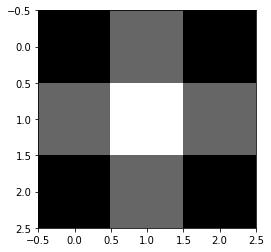

In [25]:
importlib.reload(submitted)
small_pyramid = submitted.conv2(zero_padded_square, zero_padded_square, 1)
fig,ax = plt.subplots(figsize=(5,4))
ax.imshow(small_pyramid,cmap='gray')

The second utility function that you're provided is a full `conv_layer`, that goes from $N_c$ input channels to $N_d$ output channels.  Let's create an input image with squares of three colors in the three corners, and then convolve with the triangle function in order to blur each color, without mixing the colors.

Text(0.5, 1.0, 'output image')

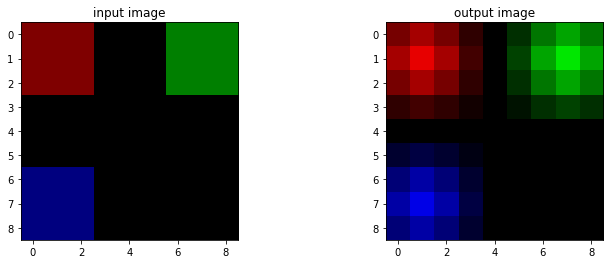

In [26]:
importlib.reload(submitted)
W = np.zeros((3,3,3,3))
for c in range(3):
    W[:,:,c,c] = small_pyramid/3
H = np.zeros((9,9,3))
H[0:3,0:3,0] = 1/2 # red is turned on in upper left corner
H[0:3,6:9,1] = 1/2 # green is turned on in upper right corner
H[6:9,0:3,2] = 1/2 # blue is turned on in lower left corner
importlib.reload(submitted)
Xi = submitted.conv_layer(H,W,1)
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].imshow(H[:,:,:])
ax[0].set_title('input image')
ax[1].imshow(Xi[:,:,:])
ax[1].set_title('output image')

You are also provided with a sigmoid  function.  This is provided for you mostly because numpy generates `NaN` if you try to compute `np.exp(x)` for x<-100 or so.  In order to simplify this, the provided function just sets sigmoid(x)==0 for x<-100.

Text(0.5, 1.0, 'Sigmoid from -4 to 4')

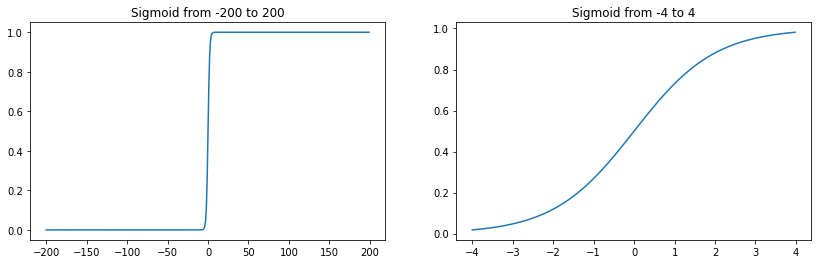

In [27]:
importlib.reload(submitted)
fig, ax = plt.subplots(1,2,figsize=(14,4))
ax[0].plot(np.arange(-200,200), submitted.sigmoid(np.arange(-200,200)))
ax[0].set_title('Sigmoid from -200 to 200')
ax[1].plot(np.arange(-200,200)/50, submitted.sigmoid(np.arange(-200,200)/50))
ax[1].set_title('Sigmoid from -4 to 4')

You are also provided with a `safe_log`  function.  This is provided for you mostly because numpy generates `NaN` if you try to compute `np.log(x)` for `x<np.exp(-100)` or so.  In order to simplify this, the provided function just sets `safe_log(x)==0` for `x<np.exp(-100)`.

Text(0.5, 1.0, 'Safe log from exp(-4) to exp(4)')

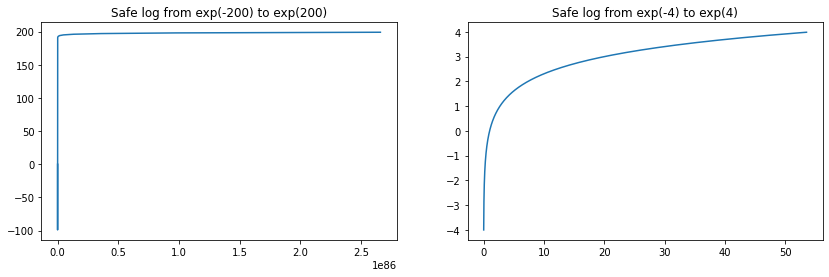

In [28]:
importlib.reload(submitted)
fig, ax = plt.subplots(1,2,figsize=(14,4))
x = np.exp(np.arange(-200,200))
ax[0].plot(x, submitted.safe_log(x))
ax[0].set_title('Safe log from exp(-200) to exp(200)')
x = np.exp(np.arange(-200,200)/50)
ax[1].plot(x, submitted.safe_log(x))
ax[1].set_title('Safe log from exp(-4) to exp(4)')

## 2.  forwardprop

`forwardprop` should compute forward-propagation through the Faster-RCNN  network.

The input is one feature tensor per input image.  The feature tensor is the last conv layer, just before the fifth max pooling  layer, from a pre-trained image classifier called VGG16 (https://neurohive.io/en/popular-networks/vgg16/).  VGG16 assumes that the input image is $224\times 224\times 3$.  There are 4 downsampling layers, so the feature tensor is $\frac{224}{2^4}\times\frac{224}{2^4}=14\times 14$ pixels, from which we've chosen the center $N_1=8$ rows and $N_2=8$  columns.  It has $N_C=512$ channels per pixel.  So let's say that the input is $x[i,n_1,n_2,c]$ in the $i^{\textrm{th}}$ image, $n_1^{\textrm{st}}$ row, $n_2^{\textrm{th}}$ column, and $c^{\textrm{th}}$ channel.

* The first layer is a $3\times 3$ convolution, followed by a ReLU nonlinearity, thus:
$$\xi^{(1)}[n_1,n_2,d] = \sum_c \sum_{m_1=-1}^1 \sum_{m_2=-1}^1 w[m_1,m_2,c,d] x[n_1-m_1,n_2-m_2,c]$$
$$h[n_1,n_2,d] = \max\left(0,\xi^{(1)}[n_1,n_2,d]\right)$$

* The second layer is what's called a $1\times 1$ convolution, which is really just a  matrix multiplication:
$$\xi^{(2)}[n_1,n_2,a,k] = \sum_d w[0,0,d,a,k] h[n_1,n_2,d]$$

* For every image $i$, for every pixel $(n_1,n_2)$, for every anchor $a$, the second layer activation has two parts: a classification part, and a regression part.  The classification part is the last ($5^{\textrm{th}}$) element, which is computed using a sigmoid:

$$\hat{y}[n_1,n_2,a,4] = \sigma\left(\xi^{(2)}[n_1,n_2,a,4]\right)$$

The regression part is all of the rest.  The regression part just uses a linear output layer:

$$\hat{y}[n_1,n_2,a,0:4] = \xi^{(2)}[n_1,n_2,a,0:4]$$

In [29]:
importlib.reload(submitted)
help(submitted.forwardprop)

Help on function forwardprop in module submitted:

forwardprop(X, W1, W2)
    Compute forward propagation of the FasterRCNN network.
    
    Inputs:
      X (N1,N2,NC) - input features
      W1 (M1,M2,NC,ND) -  weight tensor for the first layer
      W2 (1,1,ND,NA,NY) - weight tensor for the second layer
    
    Outputs:
      H (N1,N2,ND) - hidden layer activations
      Yhat (N1,N2,NA,NY) - outputs
    
    Interpretation of the outputs:
      Yhat[n1,n2,a,:4] - regression output, (n1,n2) pixel, a'th anchor
      Yhat[n1,n2,a,4] - classfication output, (n1,n2) pixel, a'th anchor



In [32]:
importlib.reload(submitted)
import time
print('Time before one image forwardprop is',time.perf_counter())
H, Yhat = submitted.forwardprop(features[0,:,:,:], W1, W2)
print('H  has the shape',H.shape,'and Yhat has the shape',Yhat.shape)
print('Time after one image forwardpropr is',time.perf_counter())

Time before one image forwardprop is 357.266919892
H  has the shape (8, 8, 128) and Yhat has the shape (8, 8, 9, 5)
Time after one image forwardpropr is 368.299628475


## 3. detect

The `detect` function  takes the output of `forwardprop`, and uses it to detect candidate face rectangles in the image.

Your  function `detect` should find the (n1,n2,a) tuples that the neural net thinks are  most probable (highest classification probability).  For each one, it should convert the regression output back into an  image rectangle, and append it to the best_rects output.  Then we can plot those best_rects on the original image.

You should not expect it to give very accurate results, yet, since the network weights have been initialized randomly, and not trained yet!


In [33]:
importlib.reload(submitted)
help(submitted.detect)

Help on function detect in module submitted:

detect(Yhat, number_to_return, anchors)
    Input:
      Yhat (N1,N2,NA,NY) - neural net outputs for just one image
      number_to_return (scalar) - the number of rectangles to return
      anchors (N1,N2,NA,NY) - the set of standard anchor rectangles
    Output:
      best_rects (number_to_return,4) - [x,y,w,h] rectangles most likely to contain faces.
      You should find the number_to_return rows, from Yhat,
      with the highest values of Yhat[n1,n2,a,4],
      then convert their corresponding Yhat[n1,n2,a,0:4] 
      from regression targets back into rectangles
      (i.e., reverse the process in rect_regression()).



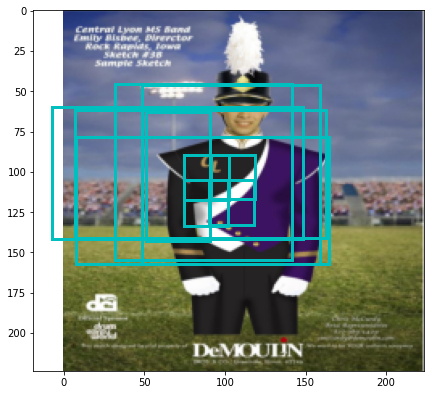

In [34]:
importlib.reload(submitted)
best_rects = submitted.detect(Yhat, 10, anchors)
show_image_with_rectangles(images[0,:,:,:],best_rects)

## 4. loss

Now we need to compute the loss.  For Faster RCNN, the loss has two parts:
$${\mathcal L} = {\mathcal L}_{MSE} + {\mathcal L}_{BCE}$$  

The MSE loss  is the average squared difference between the regression target and the regression output, averaged over only those rectangles where the ground truth says that the rectangle contains a face ($y[n_1,n_2,a,4]=1$):

$${\mathcal L}_{MSE} = \frac{1}{2}
\frac{\sum_{n_1=0}^{N_1-1}\sum_{n_2=0}^{N_2-1}\sum_{a=0}^{N_A-1} y[n_1,n_2,a,4]\times\Vert y[n_1,n_2,a,0:4]-\hat{y}[n_1,n_2,a,0:4]\Vert^2}
{\sum_{n_1=0}^{N_1-1}\sum_{n_2=0}^{N_2-1}\sum_{a=0}^{N_A-1}y[n_1,n_2,a,4]}
$$

The other term in the loss, ${\mathcal L}_{BCE}$, is the usual binary cross entropy loss for the classification output of the network ($\hat{y}[n_1,n_2,a,4]$), summed over position ($n_1,n_2$) and anchor ($a$):

$${\mathcal L}_{BCE}=-\frac{1}{N_1N_2N_A}\sum_{n_1=0}^{N_1-1}\sum_{n_2=0}^{N_2-1}\sum_{a=0}^{N_A-1}y[n_1,n_2,a,4]\ln\hat{y}[n_1,n_2,a,4]+(1-y[n_1,n_2,a,4])\ln(1-\hat{y}[n_1,n_2,a,4])$$



In [36]:
importlib.reload(submitted)
help(submitted.loss)

Help on function loss in module submitted:

loss(Yhat, Y)
    Compute the two loss terms for the FasterRCNN network, for one image.
    
    Inputs:
      Yhat (N1,N2,NA,NY) - neural net outputs
      Y (N1,N2,NA,NY) - targets
    Outputs:
      bce_loss (scalar) - 
        binary cross entropy loss of the classification output,
        averaged over all positions in the image, averaged over all anchors 
        at each position.
      mse_loss (scalar) -
        0.5 times the mean-squared-error loss of the regression output,
        averaged over all of the targets (images X positions X  anchors) where
        the classification target is  Y[n1,n2,a,4]==1.  If there are no such targets,
        then mse_loss = 0.



In [37]:
importlib.reload(submitted)
bce_loss, mse_loss = submitted.loss(Yhat, targets[0,:,:,:,:])
print('BCE loss for this image is %g, MSE loss is %g'%(bce_loss, mse_loss))

BCE loss for this image is 0.695076, MSE loss is 5.8094


Well, that's a little dissatisfying -- are those numbers large, or small?  The answer is, there's no way to know, really, until we try training the network for a while, to see if we can make those numbers smaller.

## 5. backprop

The loss function (`loss`) is really important for debugging (as we'll see later), but it's actually not necessary to train the network.  To train the network, what we really need is the **derivative** of the loss, which we can compute without ever computing the loss itself.  The derivative of the loss is

$$\nabla_\xi{\mathcal L}[n_1,n_2,a,k]=\frac{d{\mathcal L}}{d\xi[n_1,n_2,a,k]}$$

where $\xi[n_1,n_2,a,k]$ is the excitation (before the sigmoid nonlinearity)  for the $a^{\textrm{th}}$ anchor at the $(n_1,n_2)^{\textrm{th}}$ position, for the k'th network output.


In [38]:
importlib.reload(submitted)
help(submitted.backprop)

Help on function backprop in module submitted:

backprop(Y, Yhat, H, W2)
    Compute back-propagation in the Faster-RCNN network.
    Inputs:
      Y (N1,N2,NA,NY) - training targets
      Yhat (N1,N2,NA,NY) - network outputs
      H (N1,N2,ND) - hidden layer activations
      W2 (1,1,ND,NA,NY) - second-layer weights
    Outputs:
      GradXi1 (N1,N2,ND) - derivative of loss w.r.t. 1st-layer excitations
      GradXi2 (N1,N2,NA,NY) - derivative of loss w.r.t. 2nd-layer excitations



In [39]:
importlib.reload(submitted)
GradXi1, GradXi2 = submitted.backprop(targets[0,:,:,:,:],Yhat,H,W2)

Text(0.5, 1.0, '$∇_ξ^{(2)}L[n_1,n_2,:]$ loss gradient')

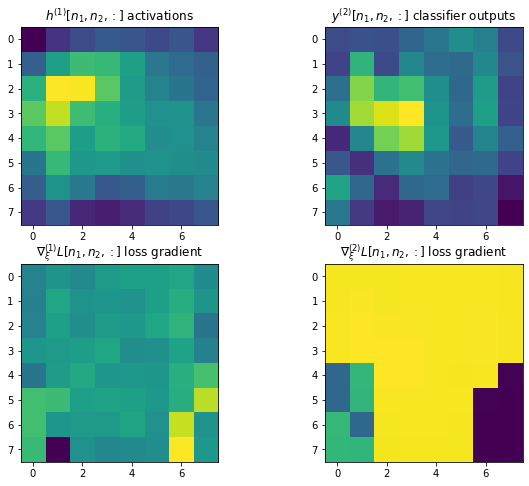

In [40]:
fig, ax = plt.subplots(2,2,figsize=(10,8))
ax[0,0].imshow(np.average(H,axis=2).T)
ax[0,0].set_title('$h^{(1)}[n_1,n_2,:]$ activations')
ax[1,0].imshow(np.average(GradXi1,axis=2).T)
ax[1,0].set_title('$∇_ξ^{(1)}L[n_1,n_2,:]$ loss gradient')
ax[0,1].imshow(np.average(Yhat[:,:,:,4],axis=2).T)
ax[0,1].set_title('$y^{(2)}[n_1,n_2,:]$ classifier outputs')
ax[1,1].imshow(np.average(GradXi2[:,:,:,4],axis=2).T)
ax[1,1].set_title('$∇_ξ^{(2)}L[n_1,n_2,:]$ loss gradient')


## 6. weight_gradient

The weight gradient is computed by taking the loss gradient w.r.t. a layer's output, multiplied by the inputs of the same layer.  Thus, for example,

$$\nabla_{W^{(1)}}{\mathcal L}[m_1,m_2,c,d]=\sum_{n_1}\sum_{n_2}\nabla_{\xi^{(1)}}{\mathcal L}[n_1-m_1,n_2-m_2,d]x[n_1,n_2,c],~~-1\le m_1\le 1,-1\le m_2\le 1$$

$$\nabla_{W^{(2)}}{\mathcal L}[0,0,d,a,k]=\sum_{n_1}\sum_{n_2}\nabla_{\xi^{(2)}}{\mathcal L}[n_1,n_2,a,k]h[n_1,n_2,d]$$

In [41]:
importlib.reload(submitted)
help(submitted.weight_gradient)

Help on function weight_gradient in module submitted:

weight_gradient(X, H, GradXi1, GradXi2, M1, M2)
    Compute weight gradient in the Faster-RCNN network.
    Inputs:
      X (N1,N2,NC) - network inputs
      H (N1,N2,ND) - hidden-layer activations
      GradXi1 (N1,N2,ND) - gradient of loss w.r.t. layer-1 excitations
      GradXi2 (N1,N2,NA,NY) - gradient of loss w.r.t. layer-2 excitations
      M1 - leading dimension of W1
      M2 - second dimension of W1
    Outputs:
      dW1 (M1,M2,NC,ND) - gradient of loss w.r.t. layer-1 weights
      dW2 (1,1,ND,NA,NY) -  gradient of loss w.r.t. layer-2 weights



Here's the same thing for your submitted.py code:

In [42]:
importlib.reload(submitted)
dW1,dW2 = submitted.weight_gradient(features[0,:,:,:],H,GradXi1,GradXi2,3,3)

             

Text(0.5, 0, 'hidden node number $d$')

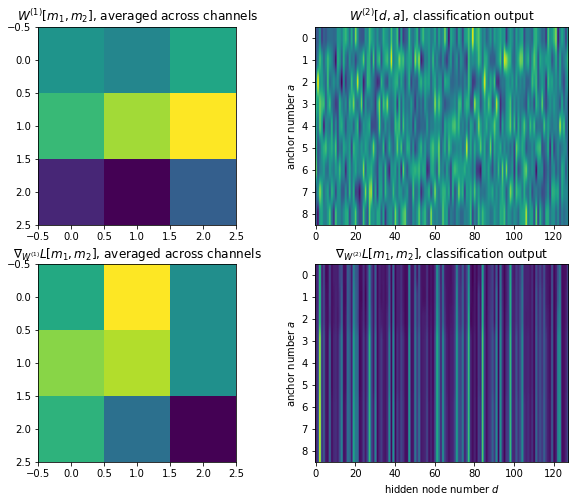

In [43]:
fig, ax = plt.subplots(2,2,figsize=(10,8))
ax[0,0].imshow(np.average(W1,axis=(2,3)).T)
ax[0,0].set_title('$W^{(1)}[m_1,m_2]$, averaged across channels')
ax[1,0].imshow(np.average(dW1,axis=(2,3)).T)
ax[1,0].set_title('$∇_{W^{(1)}}L[m_1,m_2]$, averaged across channels')
ax[0,1].imshow(W2[0,0,:,:,4].T,aspect='auto')
ax[0,1].set_title('$W^{(2)}[d,a]$, classification output')
ax[0,1].set_ylabel('anchor number $a$')
ax[1,1].imshow(dW2[0,0,:,:,4].T,aspect='auto')
ax[1,1].set_title('$∇_{W^{(2)}}L[m_1,m_2]$, classification output')
ax[1,1].set_ylabel('anchor number $a$')
ax[1,1].set_xlabel('hidden node number $d$')

## 7. weight_update

The weight update is just computed by subtracting the gradient, multiplied by a learning rate $\eta$:

$$W^{(1)}[m_1,m_2,c,d] = W^{(1)}[m_1,m_2,c,d]-\eta\nabla_{W^{(1)}}{\mathcal L}[m_1,m_2,c,d]$$

$$W^{(2)}[0,0,d,a,k]=W^{(2)}[0,0,d,a,k]-\eta\nabla_{W^{(2)}}{\mathcal L}[0,0,d,a,k]$$

In [44]:
importlib.reload(submitted)
help(submitted.weight_update)

Help on function weight_update in module submitted:

weight_update(W1, W2, dW1, dW2, learning_rate)
    Input: 
      W1 (M1,M2,NC,ND) = first layer weights
      W2 (1,1,ND,NA,NY) = second layer weights
      dW1 (M1,M2,NC,ND) = first layer weights
      dW2 (1,1,ND,NA,NY) = second layer weights
      learning_rate = scalar learning rate
    Output:
      new_W1 (M1,M2,NC,ND) = first layer weights
      new_W2 (1,1,ND,NA,NY) = second layer weights



In [45]:
importlib.reload(submitted)
new_W1, new_W2 = submitted.weight_update(W1,W2,dW1,dW2,0.0001)

Text(0.5, 0, 'hidden node number $d$')

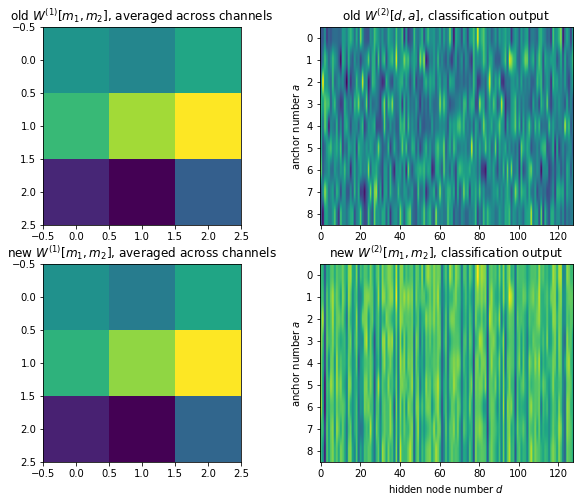

In [46]:
fig, ax = plt.subplots(2,2,figsize=(10,8))
ax[0,0].imshow(np.average(W1,axis=(2,3)).T)
ax[0,0].set_title('old $W^{(1)}[m_1,m_2]$, averaged across channels')
ax[1,0].imshow(np.average(new_W1,axis=(2,3)).T)
ax[1,0].set_title('new $W^{(1)}[m_1,m_2]$, averaged across channels')
ax[0,1].imshow(W2[0,0,:,:,4].T,aspect='auto')
ax[0,1].set_title('old $W^{(2)}[d,a]$, classification output')
ax[0,1].set_ylabel('anchor number $a$')
ax[1,1].imshow(new_W2[0,0,:,:,4].T,aspect='auto')
ax[1,1].set_title('new $W^{(2)}[m_1,m_2]$, classification output')
ax[1,1].set_ylabel('anchor number $a$')
ax[1,1].set_xlabel('hidden node number $d$')

## 8. Debugging: Check to make sure that the loss is decreasing

Back-propagation is really difficult to debug.  If you made a mistake in all of those previous  steps  (and if you didn't have this MP's reference solutions to compare to), how would you know?

One  useful method is to try several steps forward and backward along the gradient, and measure the loss at each step.  If the gradient  was computed correctly, you should see that loss increases in the direction of the gradient, and decreases in the direction of the negative gradient.

We can do this by trying several different values of the "learning rate" (which is a sort of normalized step size), and then plotting the loss as  a function of the step size.

In [47]:
importlib.reload(submitted)
steps_to_try = np.arange(-10,11)/10000
bce_losses = np.zeros(steps_to_try.shape)
mse_losses = np.zeros(steps_to_try.shape)
for t,stepsize in enumerate(steps_to_try):
    W1_tmp, W2_tmp = submitted.weight_update(W1,W2,dW1,dW2,stepsize)
    H_tmp, Yhat_tmp = submitted.forwardprop(features[0,:,:,:], W1_tmp, W2_tmp)
    bce_losses[t], mse_losses[t] = submitted.loss(Yhat_tmp, targets[0,:,:,:,:])
    print('Step %d (step %g): bce_loss=%g, mse_loss=%g'%(t,stepsize,bce_losses[t],mse_losses[t]))


Step 0 (step -0.001): bce_loss=-0, mse_loss=28417.8
Step 1 (step -0.0009): bce_loss=-0, mse_loss=18815
Step 2 (step -0.0008): bce_loss=-0, mse_loss=11888.6
Step 3 (step -0.0007): bce_loss=0.0625758, mse_loss=7085.96
Step 4 (step -0.0006): bce_loss=0.43611, mse_loss=3918.5
Step 5 (step -0.0005): bce_loss=1.39533, mse_loss=1962.11
Step 6 (step -0.0004): bce_loss=6.7684, mse_loss=857.044
Step 7 (step -0.0003): bce_loss=14.1277, mse_loss=307.821
Step 8 (step -0.0002): bce_loss=13.6698, mse_loss=83.3442
Step 9 (step -0.0001): bce_loss=3.71005, mse_loss=16.8123
Step 10 (step 0): bce_loss=0.695076, mse_loss=5.8094
Step 11 (step 0.0001): bce_loss=0.220034, mse_loss=2.85048
Step 12 (step 0.0002): bce_loss=0.394649, mse_loss=9.11563
Step 13 (step 0.0003): bce_loss=0.852814, mse_loss=62.7603
Step 14 (step 0.0004): bce_loss=1.49357, mse_loss=226.074
Step 15 (step 0.0005): bce_loss=2.31297, mse_loss=585.43
Step 16 (step 0.0006): bce_loss=3.31087, mse_loss=1251.33
Step 17 (step 0.0007): bce_loss=3.1

Text(0.5, 1.0, 'MSE loss as a function of step size in negative-weight-gradient direction')

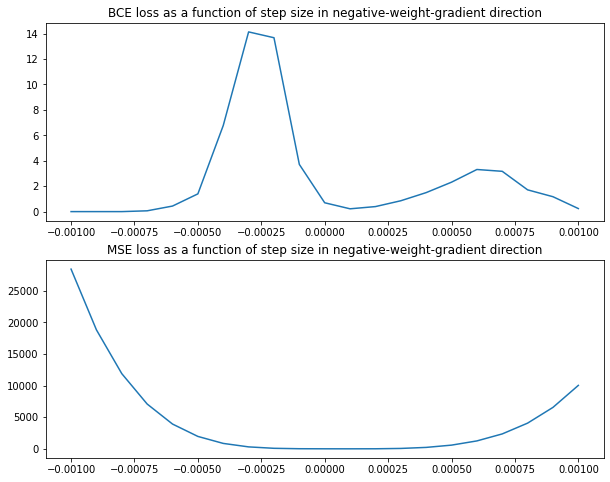

In [48]:
fig, ax = plt.subplots(2,1,figsize=(10,8))
ax[0].plot(steps_to_try,bce_losses)
ax[0].set_title('BCE loss as a function of step size in negative-weight-gradient direction')
ax[1].plot(steps_to_try,mse_losses)
ax[1].set_title('MSE loss as a function of step size in negative-weight-gradient direction')


## 9. Conclusion

Congratulations --- you've learned how to train a Faster-RCNN object detector! 

BTW, you probably noticed that this whole Jupyter notebook has only carried out training on one image.  The so-called training set has only 50 images, which is still not enough to train such a  large neural net.  If you really wanted to train a successful face-detection neural net, you'd probably want to use the whole WIDER-face dataset, and you'd want to run many epochs of training, probably on a GPU, using a second-order optimization method like LBFGS or Adam, probably using a package like pytorch.

The main steps, however, would still be the same as those we've done here:
1. forwardprop
2. backprop
3. weight_gradient
4. weight_update
5. measure the loss, to make sure it's still decreasing.  If it isn't, stop training.
